# Iterative Methods for Solving Linear Systems

In [1]:
import numpy as np
def ind(i,j,n):
    return i+j*(n+1)

In [2]:
def formingLinearSystem(n, g):
    h = 1/n
    A = np.eye((n+1)**2)
    b = np.zeros((n+1)**2)
    for i in range(1,n):
        for j in range(1,n):
            A[ind(i,j,n),ind(i,j,n)] = 4
            A[ind(i,j,n),ind(i-1,j,n)] = -1
            A[ind(i,j,n),ind(i+1,j,n)] = -1
            A[ind(i,j,n),ind(i,j-1,n)] = -1
            A[ind(i,j,n),ind(i,j+1,n)] = -1
            b[ind(i,j,n)] = g(j*h,i*h)*h*h
    return A, b

In [3]:
g = lambda x,y: x*(1-x)+y*(2-y)
n = 50
A, b = formingLinearSystem(n, g)

### Exercise on lambda function
Can you write a lambda function f(x) = x*x-2*x?

### How do we solve the system?

* Direct method such as LU
linalg.solve is a build-in function that solves Ax=b using LU factorization

* Iterative method, such as Jacobi, Gauss-seidel. 
This will be introduced next time.
    

In [4]:
from numpy import linalg
u = linalg.solve(A,b)

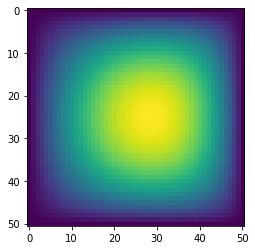

In [6]:
import matplotlib.pyplot as plt
plt.imshow(u.reshape(n+1,n+1))

In [7]:
np.allclose(A@u,b) # solved correctly! 

True

In [8]:
# most straightforward implementation
def Jacobi1(A, b, num_iter):
    x = np.zeros_like(b)
    x_new = np.zeros_like(b)
    rows, cols = A.shape
    for k in range(num_iter):
        for i in range(rows):
            r = b[i]
            for j in range(cols):
                if j != i:
                    r -= A[i,j]*x[j]
            x_new[i] = r/A[i,i]
        np.copyto(x,x_new)
    return x


In [12]:
def Jacobi2(A, b, num_iter):
    x = np.zeros_like(b)
    x_new = np.zeros_like(b)
    rows, cols = A.shape
    for k in range(num_iter):
        for i in range(rows):
            x_new[i] = (b[i] - A[i,:]@x)/A[i,i]+x[i]
        np.copyto(x,x_new)
    return x

In [38]:
def Jacobi3(A, b, num_iter):
    x = np.zeros_like(b)
    x_new = np.zeros_like(b)
    rows, cols = A.shape
    D = A.diagonal()
    res = np.zeros(num_iter)
    for k in range(num_iter):
        tmp = b-A@x
        x_new = tmp/D+x
        np.copyto(x,x_new)
        res[k] = np.linalg.norm(tmp,2)
    return x, res

In [43]:
def GS1(A, b, num_iter):
    x = np.zeros_like(b)
    rows, cols = A.shape
    D = A.diagonal()
    res = np.zeros(num_iter)
    for k in range(num_iter):
        for i in range(rows):
            tmp = b[i]-A[i,:]@x
            x[i] += tmp/D[i]
        res[k] = np.linalg.norm(b-A@x,2)
    return x, res

In [19]:
import time
A, b = formingLinearSystem(n, g)
t1 = time.time()
x = Jacobi3(A, b, 100)
t2 = time.time()
print(t2-t1)

0.371570348739624

## Now we are switching to sparse matrices for more speed up

Sparse matrices are implemented in scipy under different formats. 
Two useful formats are:
* CSR -- Compressed Sparse Row format, good for Matrix Vector multiplication
* DOK -- Dictionary of Keys format, good for forming the sparse matrix entry by entry. 

In [22]:
import numpy as np
from scipy.sparse import dok_matrix
S = dok_matrix((5, 5), dtype=np.float32)
for i in range(5):
    for j in range(5):
        S[i, j] = i + j

In [26]:
def formingSparseLinearSystem(n, g):
    h = 1/n
    A = dok_matrix(((n+1)**2,(n+1)**2), dtype = np.float64)
    b = np.zeros((n+1)**2)
    for i in range(n+1):
        for j in range(n+1):
            if 0<i<n and 0<j<n:
                A[ind(i,j,n),ind(i,j,n)] = 4
                A[ind(i,j,n),ind(i-1,j,n)] = -1
                A[ind(i,j,n),ind(i+1,j,n)] = -1
                A[ind(i,j,n),ind(i,j-1,n)] = -1
                A[ind(i,j,n),ind(i,j+1,n)] = -1
                b[ind(i,j,n)] = g(j*h,i*h)*h*h
            else:
                A[ind(i,j,n),ind(i,j,n)] = 1
                b[ind(i,j,n)] = 0
    A = A.tocsr()
    return A, b


In [45]:
As, bs = formingSparseLinearSystem(n, g)
print(type(As))
import time
A, b = formingLinearSystem(n, g)
t1 = time.time()
x_j, r_j = Jacobi3(As, bs, 10000)
t2 = time.time()
print(t2-t1)
t1 = time.time()
x_gs, r_gs = GS1(A, b, 10000)
t2 = time.time()
print(t2-t1)

<class 'scipy.sparse.csr.csr_matrix'>
0.29999685287475586


KeyboardInterrupt: 

4.907507542557804e-09

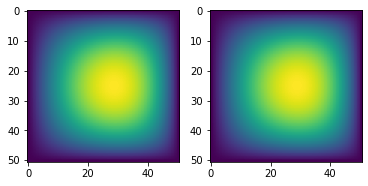

In [40]:
plt.subplot(1,2,1)
plt.imshow(u.reshape(n+1,n+1))
plt.subplot(1,2,2)
plt.imshow(x.reshape(n+1,n+1))
np.linalg.norm(u-x,2)

$L_2$ norm is a way to check error:

$$\|\vec{x}-\vec{y}\|_2=\sqrt{\sum_{i=0}^n|x_i-y_i|^2}$$

One can also check residue to see if the iterative method converges

$$r = \|A\vec{x}-\vec{b}\|_2$$

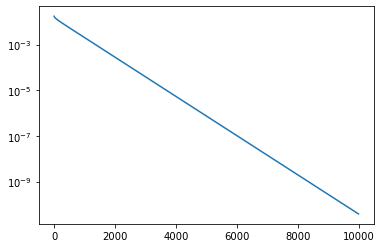

In [42]:
plt.plot(r)
plt.yscale("log")